# Insurance Claims- Fraud Detection

Insurance fraud is a huge problem in the industry. It's difficult to identify fraud claims. Machine Learning is in a unique position to help the Auto Insurance industry with this problem.

In this project, you are provided a dataset which has the details of the insurance policy along with the customer details. It also has the details of the accident on the basis of which the claims have been made. 

In this example, you will be working with some auto insurance data to demonstrate how you can create a predictive model that predicts if an insurance claim is fraudulent or not.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,FunctionTransformer,power_transform
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
import six
import sys
sys.modules['sklearn.externals.six']=six
import mlrose
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
!pip install scikit-plot
import scikitplot as skplt
from lightgbm import LGBMClassifier

In [2]:
data=pd.read_csv('insurance.csv')
data

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [3]:
{column:len(data[column].unique()) for column in data.columns if data[column].dtypes=='object'}

{'policy_bind_date': 951,
 'policy_state': 3,
 'policy_csl': 3,
 'insured_sex': 2,
 'insured_education_level': 7,
 'insured_occupation': 14,
 'insured_hobbies': 20,
 'insured_relationship': 6,
 'incident_date': 60,
 'incident_type': 4,
 'collision_type': 4,
 'incident_severity': 4,
 'authorities_contacted': 5,
 'incident_state': 7,
 'incident_city': 7,
 'incident_location': 1000,
 'property_damage': 3,
 'police_report_available': 3,
 'auto_make': 14,
 'auto_model': 39,
 'fraud_reported': 2}

Checking which column have how many unique values

In [4]:
data.isna().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

There is a missing value in last column but this whole column is empty so i will drop it

In [5]:
data.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

# Cleaning of the data Preprocessing

In [7]:
def preprocess1(df):
    df=df.copy()
    #Feature Engineering
    df['policy_bind_date']=pd.to_datetime(df['policy_bind_date'])
    df['policy_bind_year']=df['policy_bind_date'].dt.year
    df['policy_bind_month']=df['policy_bind_date'].dt.month
    df['policy_bind_day']=df['policy_bind_date'].dt.day
    #Dropping columns
    df.drop(['_c39','policy_bind_date','incident_location','incident_date'],axis=1,inplace=True)
    return df

In [8]:
data=preprocess1(data)

In [9]:
col=['authorities_contacted','auto_make','auto_model','collision_type','fraud_reported','incident_city','incident_severity','incident_state',
'incident_type','insured_education_level','insured_hobbies','insured_occupation','insured_relationship','insured_sex','police_report_available',
'policy_csl','policy_state','property_damage','policy_bind_year','policy_bind_month']

# Univariate Analysis

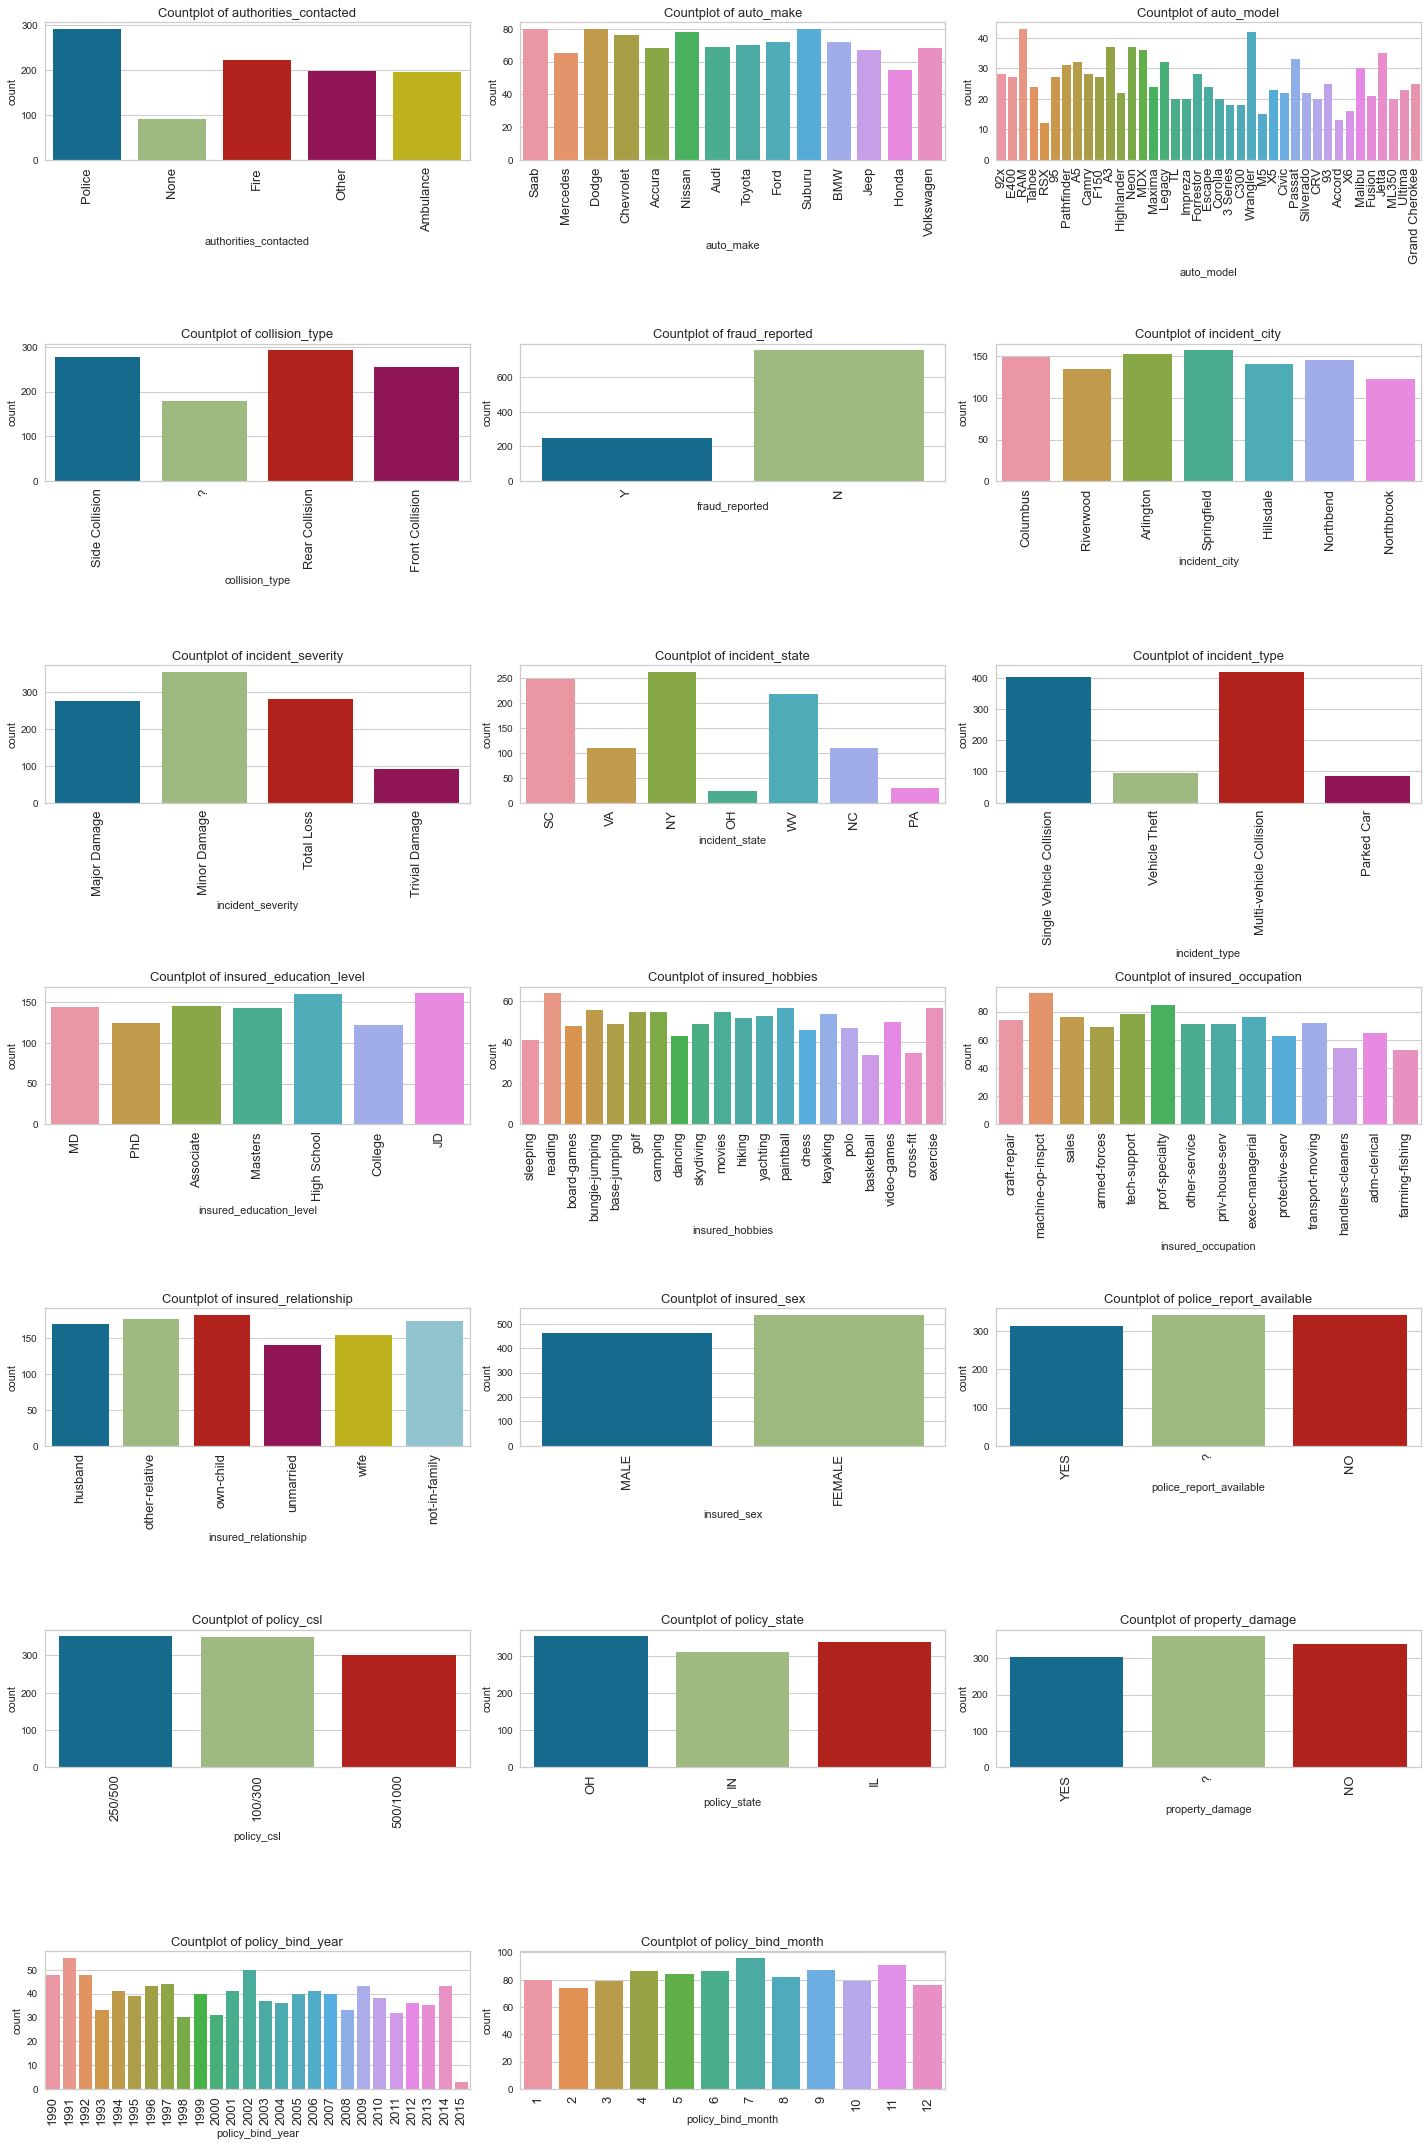

In [10]:
plt.figure(figsize=(20,65))
for i in range(len(col)):
    plt.subplot(15,3,i+1)
    sns.countplot(data[col[i]])
    plt.title(f"Countplot of {col[i]}",fontsize=13)
    plt.xticks(rotation=90,fontsize=13)
    plt.tight_layout()

# Obseravtion

1-From authorities_contacted i can say police has the high count means people have contacted police first

2-From auto_make i can say Suburu,Dodge,Saab has the high count mean they make more vehicle and honda and mercedes have less count.

3-From collision_type i can say rear collision has high count means people damage there cars most probably from back side then side and then from front side

4-Fraud Reported No has high count and yes have less count means fraud claim is less

5-From incident_city i can say Springfield has high count means in Springfield there are high chances of getting accident and Northbrook has less count mean there are less chances of accident as compare to Springfield

6-From incident_severity Minor damange has high count means mostly people claim insurance for minor damage and total loss and major damage has same count means after minor damage people goes for these two for insurance claim

7-From incident_state new york has the high count means mostly accident happens there only and Ohio has the least count as comapre to all means ohio has very less chance of accident

8-From incident type i can say Multi-vehicle Collision and Single-vehicle Collision has the high count means mostly accident happens with multiple vehicle and singlw vehicle and very less accident happens with park cars

9-from insured education level i can say JD and High school has same count means mostly people who claim insurance have these education

10-From insured_hobbies i can say reading is most popular

11-From insured_occupation i can say machine-op-inspct has high count means most of the people who claim insurance has this occupation and people who have farming-fishing occupation has less claim insurance

12-From insured_relationship own-child has high count means most of the people who have claimed insurance has child and unmaried has the least count

13-From insured sex i can say male are less female are high means people who have sex female has claimed insurance more

14-From policy cls i can say250/500 and 100/300 has same high count and 500/100 has less count

15-From policy state i can say IN has less count and Il and ch has smae high count

16-From property damage ? and No has high count and yes has less count

17-From policy bind year i can say mostly people have taken policy in 1991 and 2002 and only few people have taken policy in 2015

In [11]:
col1=['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year', 'policy_bind_year', 'policy_bind_month',
       'policy_bind_day']

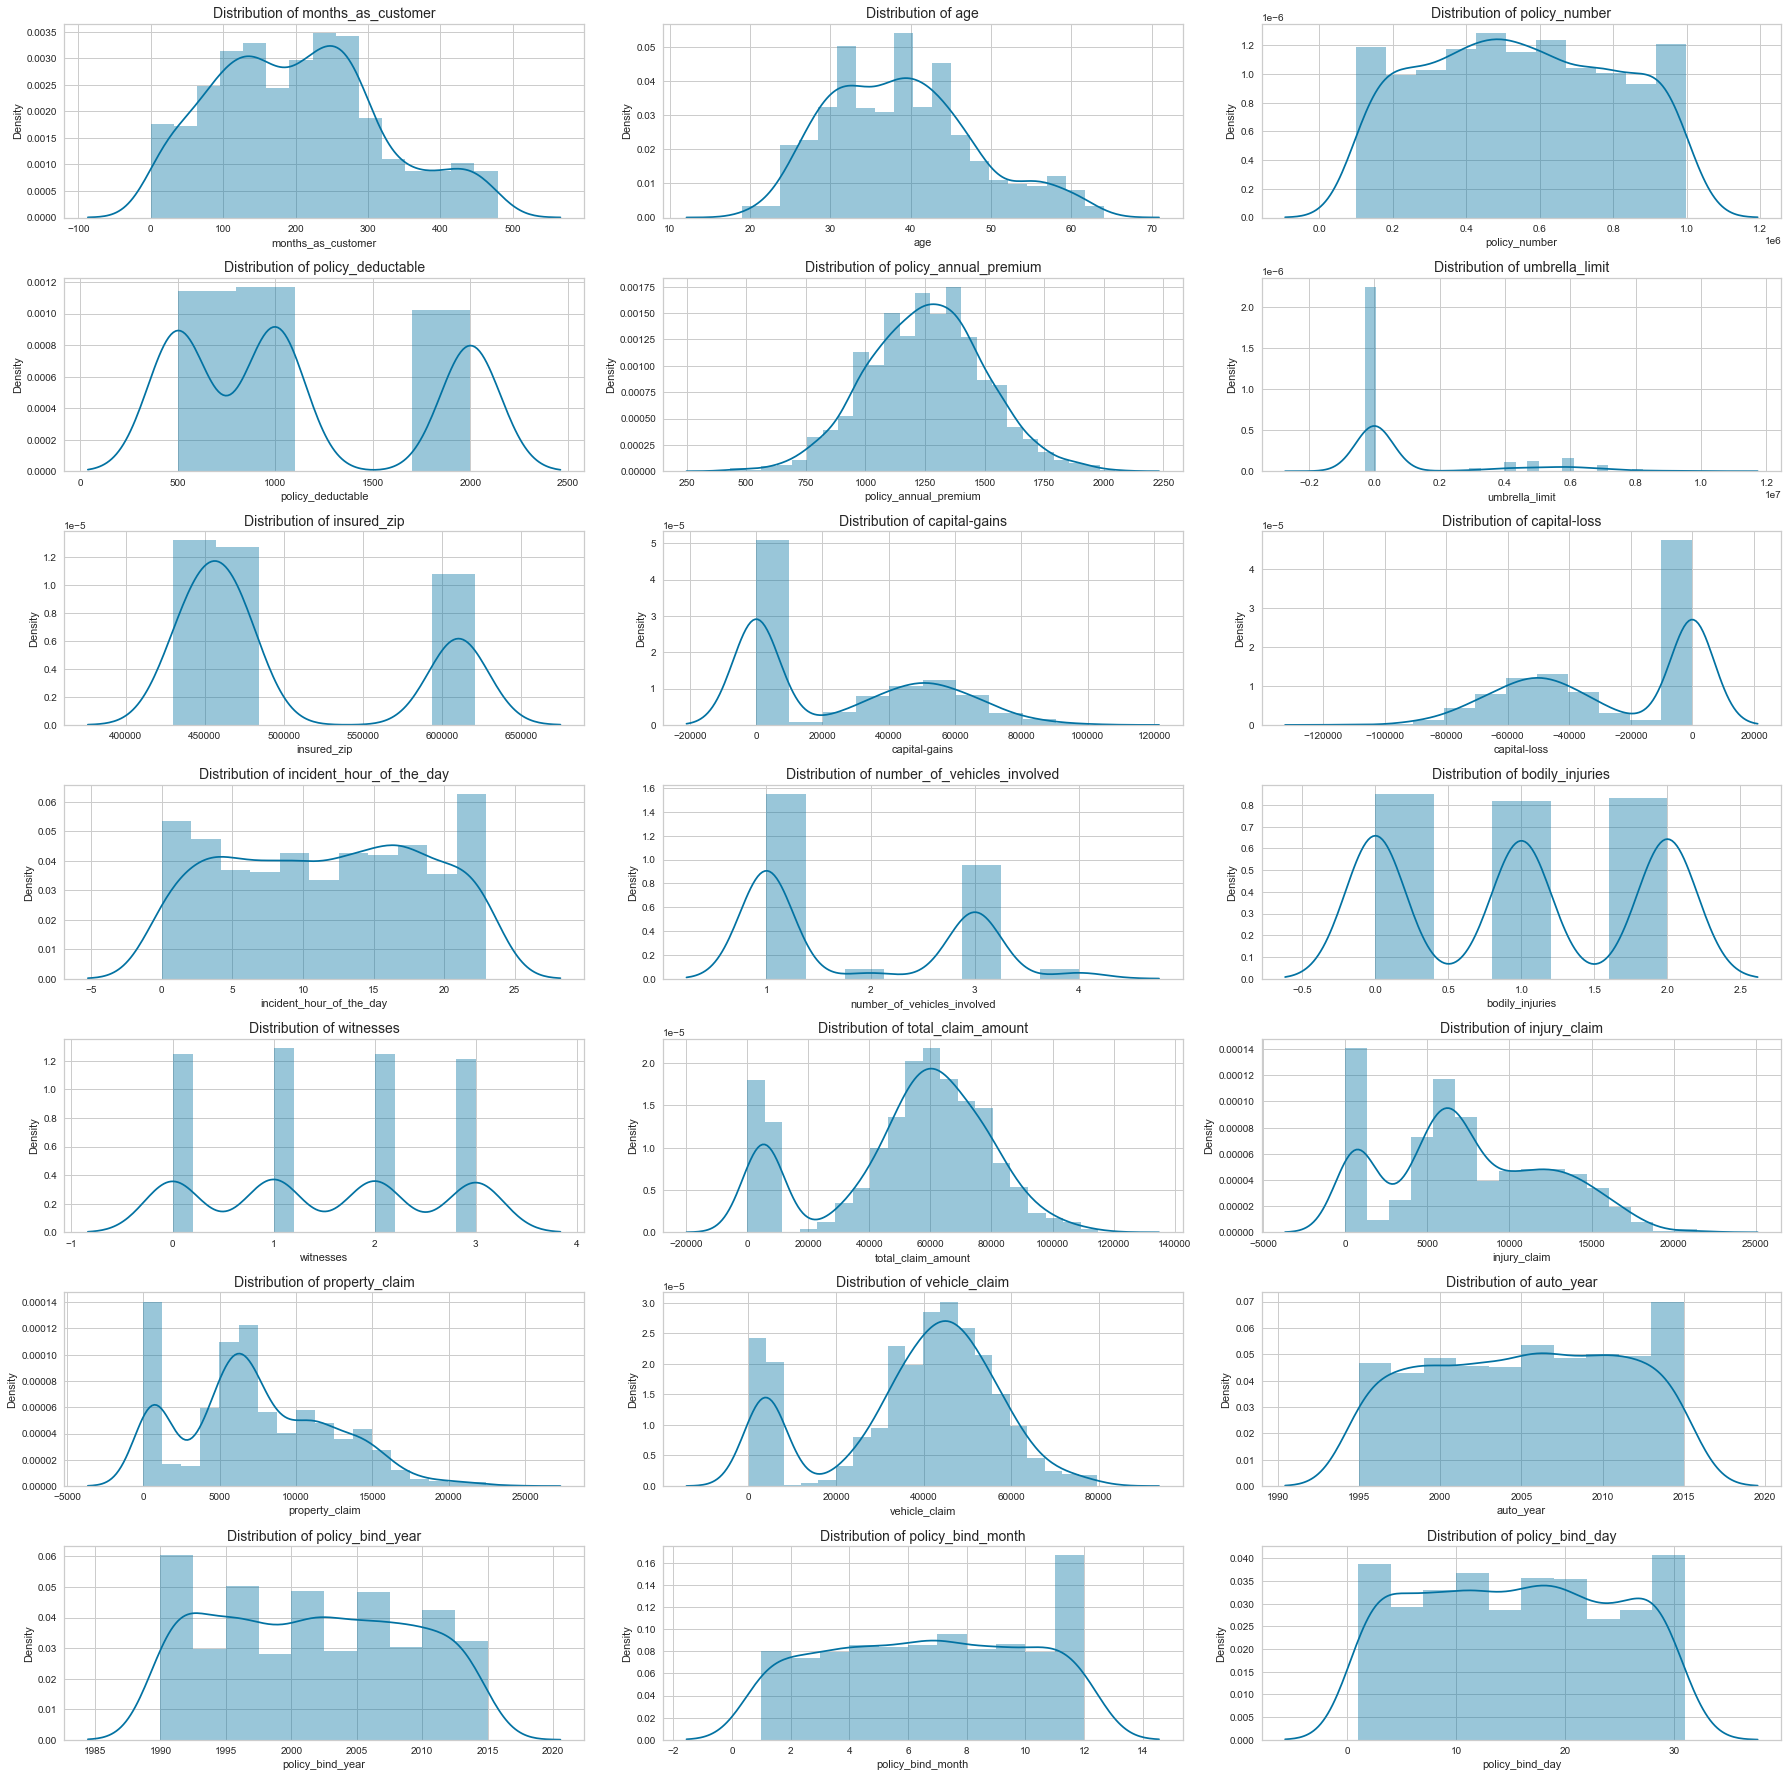

In [12]:
plt.figure(figsize=(25,35))
for i in range(len(col1)):
    plt.subplot(10,3,i+1)
    plt.title(f"Distribution of {col1[i]}",fontsize=14)
    sns.distplot(data[col1[i]])
    plt.tight_layout()

# Obseravtion

1-From months_As_customers i can say mostly people lies in 0-100 and there are less no. of people who lies in 300-500 who are loyal customers

2-From distribution of age i can say mostly people lies between 30-45 and less people are in between 50-60

3-From policy_annual_premium i can say it is normally distributed

4-From policy deductable i can say the value is between 500-1000 and 17000-20000

5-From capital gain i can say 0-10000 has high peak and with capital loss 0 to -10000 has high peak rest of the distribution are same both both feature

6-From total_claim_amount 0-10000 has high peak and rest of all values are normally distributed

7-From distribution of property claim i can say mostly people have claim 0-1000 values and from 4000-10000 these are 2nd highest people who claim for this values and There are very few people who claim 20000-25000 values

8-From distribution of vehicle claim i can say There are many people who claim for 0-10000 and rest of the value has normal distribution

# Bivariate analysis

Total claim amount and Vehicle claim on year

Text(0.5, 1.0, 'Total claim amount and Vehicle claim on year')

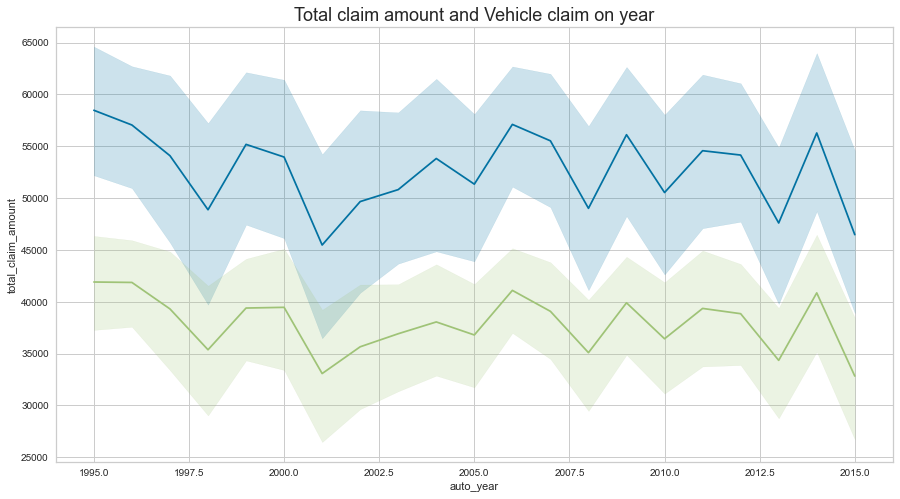

In [13]:
plt.figure(figsize=(15,8))
sns.lineplot(x='auto_year',y='total_claim_amount',data=data)
sns.lineplot(x='auto_year',y='vehicle_claim',data=data)
plt.title("Total claim amount and Vehicle claim on year",fontsize=18)

From upper graph i can say total claim amount and vehicle claim have same distribution but there is a difference of value total claim amount has high value and vehicle claim has low count

In [14]:
data1=data.select_dtypes(include='object')

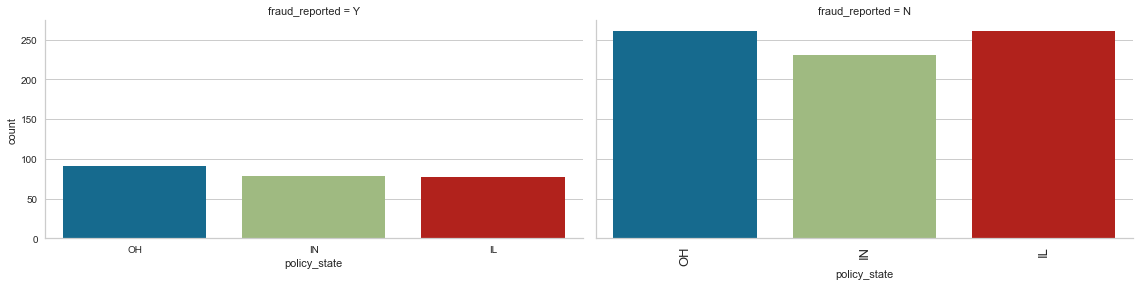

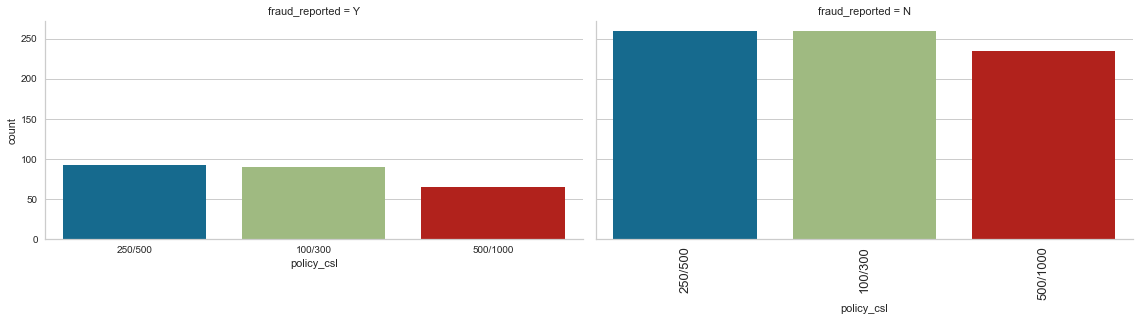

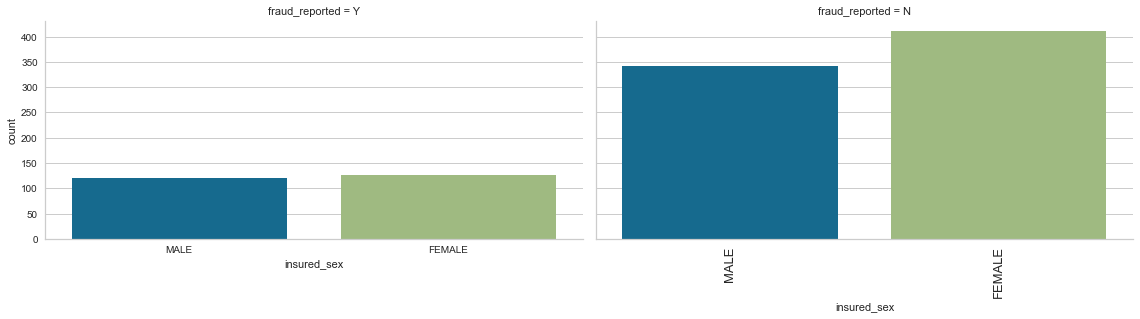

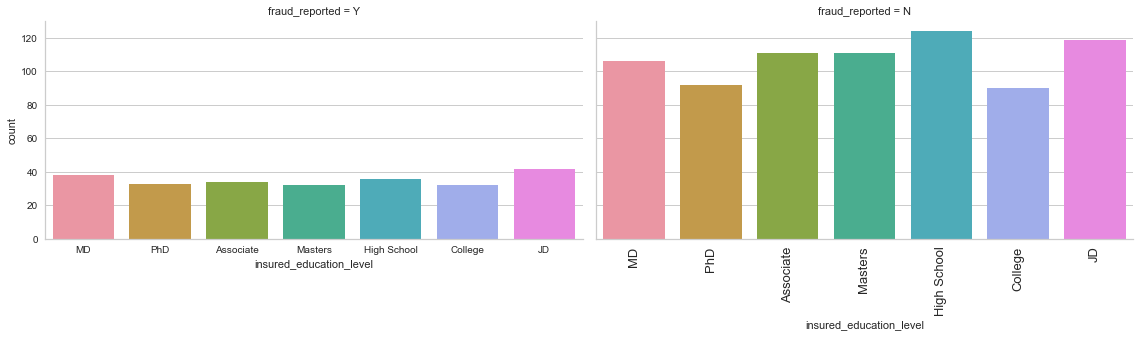

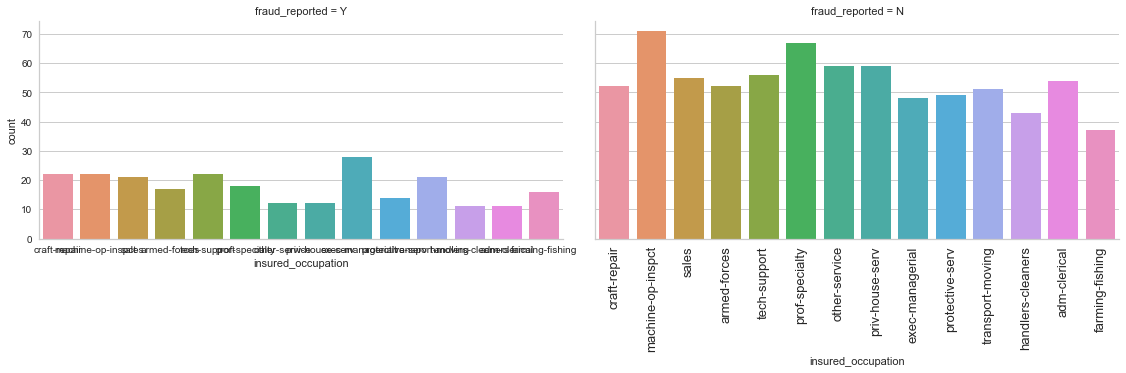

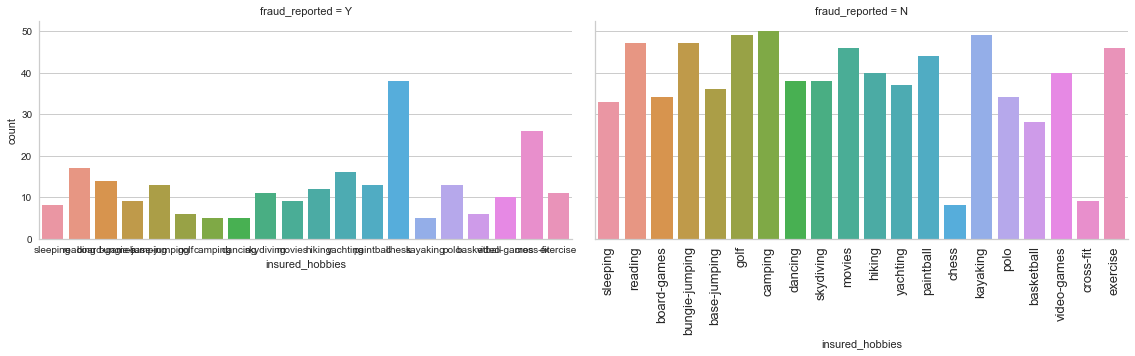

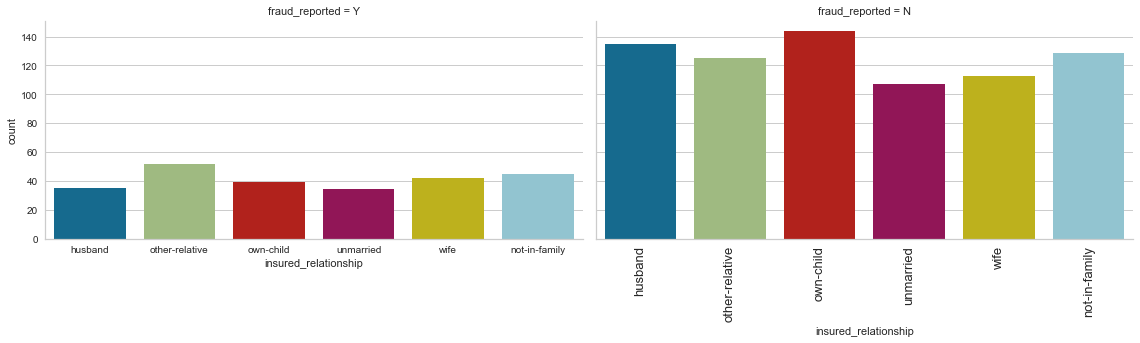

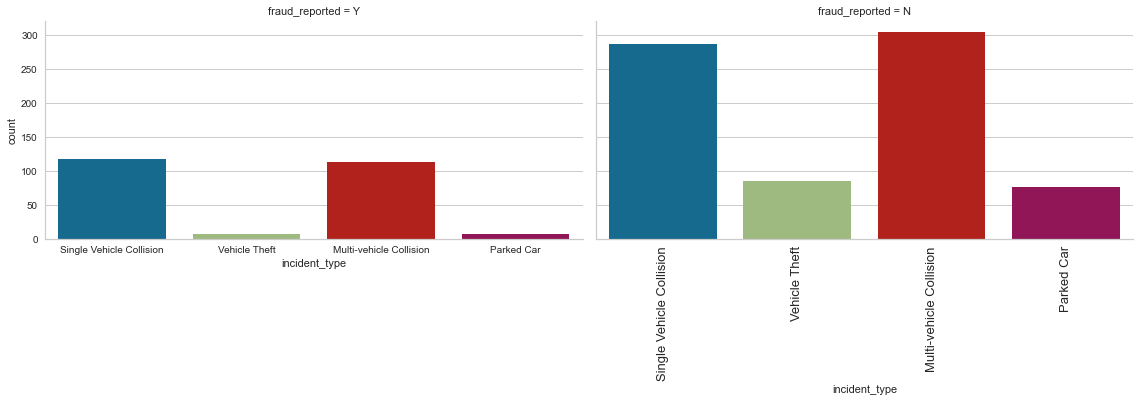

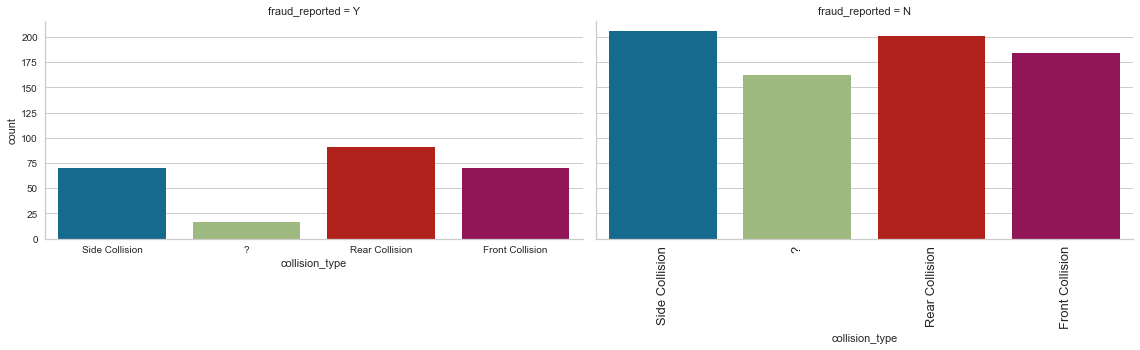

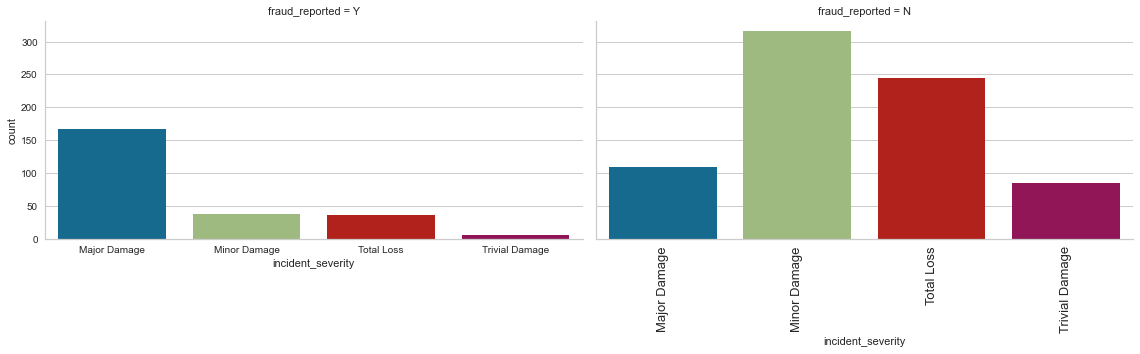

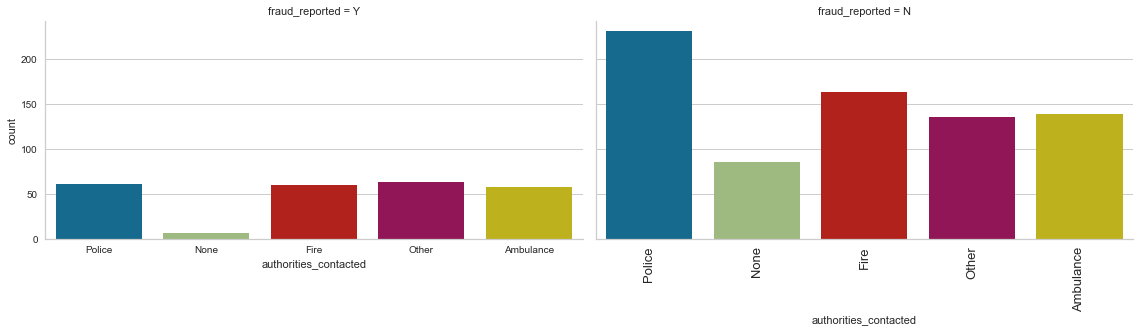

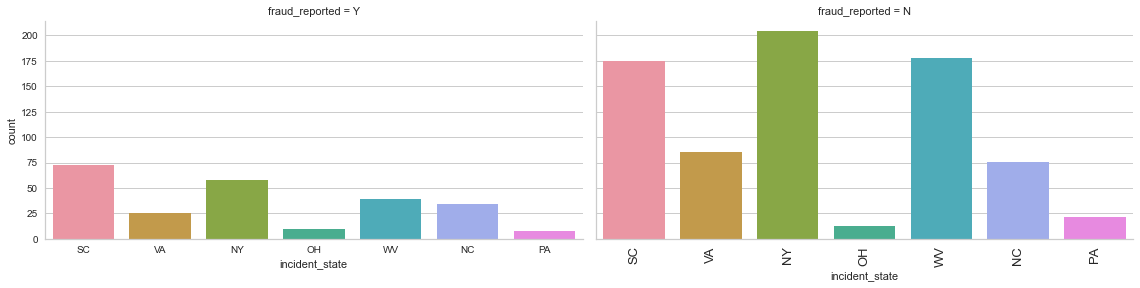

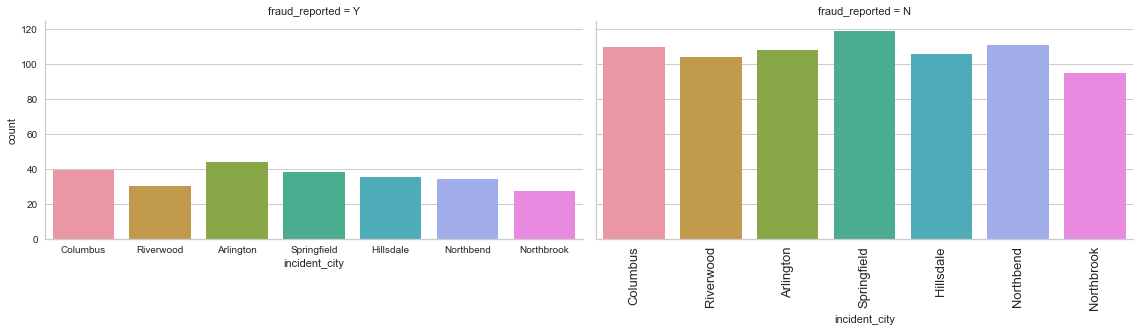

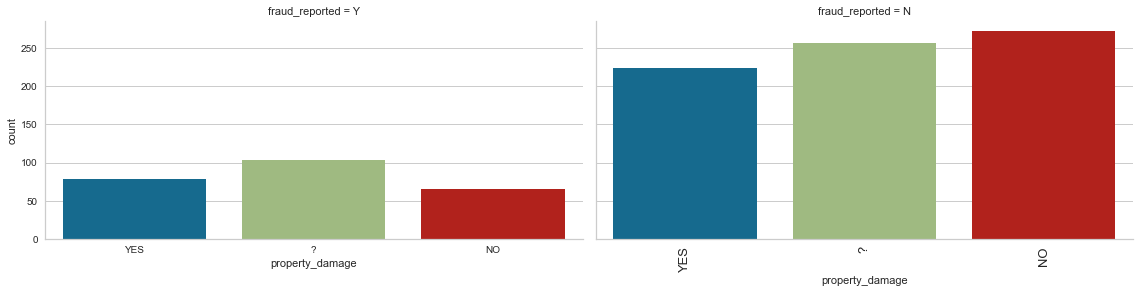

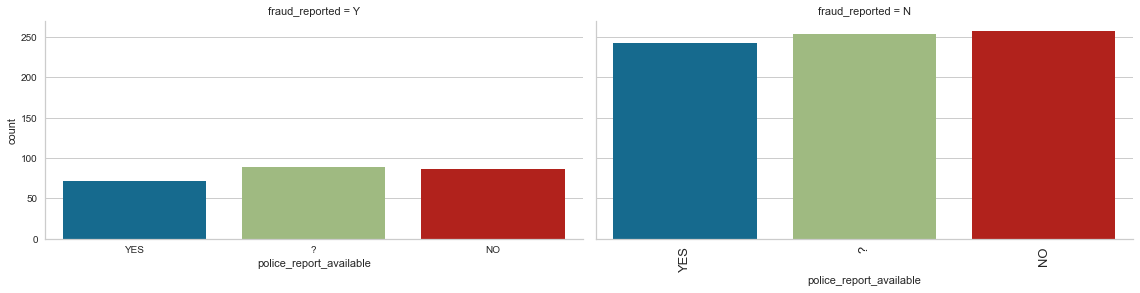

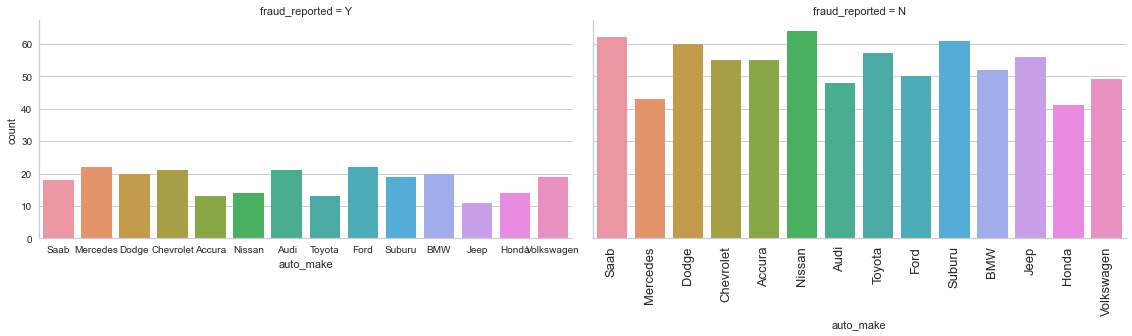

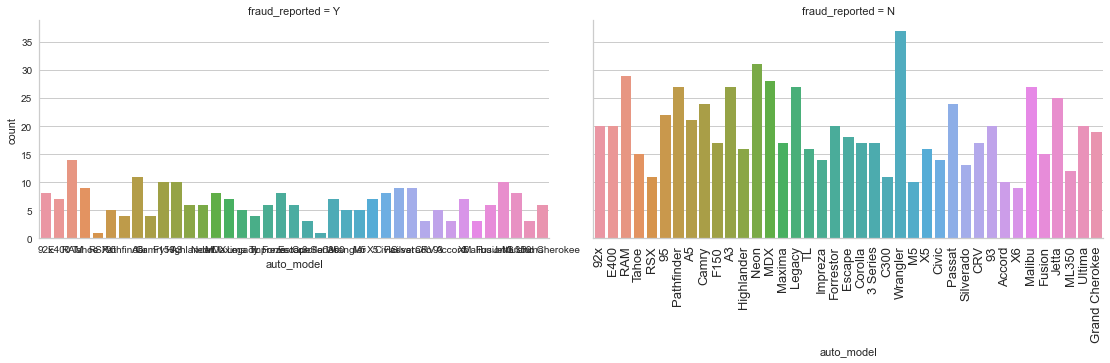

In [15]:
new_data=list(data1.columns)
new_list=new_data
new_data.remove('fraud_reported')
for col in new_list:
    sns.catplot(x=col,col='fraud_reported',data=data1,kind='count',height=4,aspect=2)
    plt.xticks(rotation=90,fontsize=13)

# People who claim for fraud insurance

1-People who claim fraud have high value of CH of policy state

2-People who claim fraud have equal gender male and female have equal count

3-Mostly People who claimed fraud there hobbies are chess i thing they claimed for fraud because they like to use there mind like we use to play chess

4-Mostly people who claimed fraud have relationship status other-relative

5-Mostly people who claimed fraud have incident_type status single and multi-vehicle collision

6-Mostly people who claimed fraud have collision_type status of Rear collision and very less people who claim unknown(?)

7-Mostly People who claimed fraud have incident_severity status major damage and very less people who have status trivial damage

8-Mostly People who claimed fraud have incident_state SC who claimed more fraud

In [16]:
data_no=data.query("fraud_reported=='Y'")

In [17]:
col3=['policy_annual_premium','total_claim_amount','injury_claim','property_claim', 'vehicle_claim']

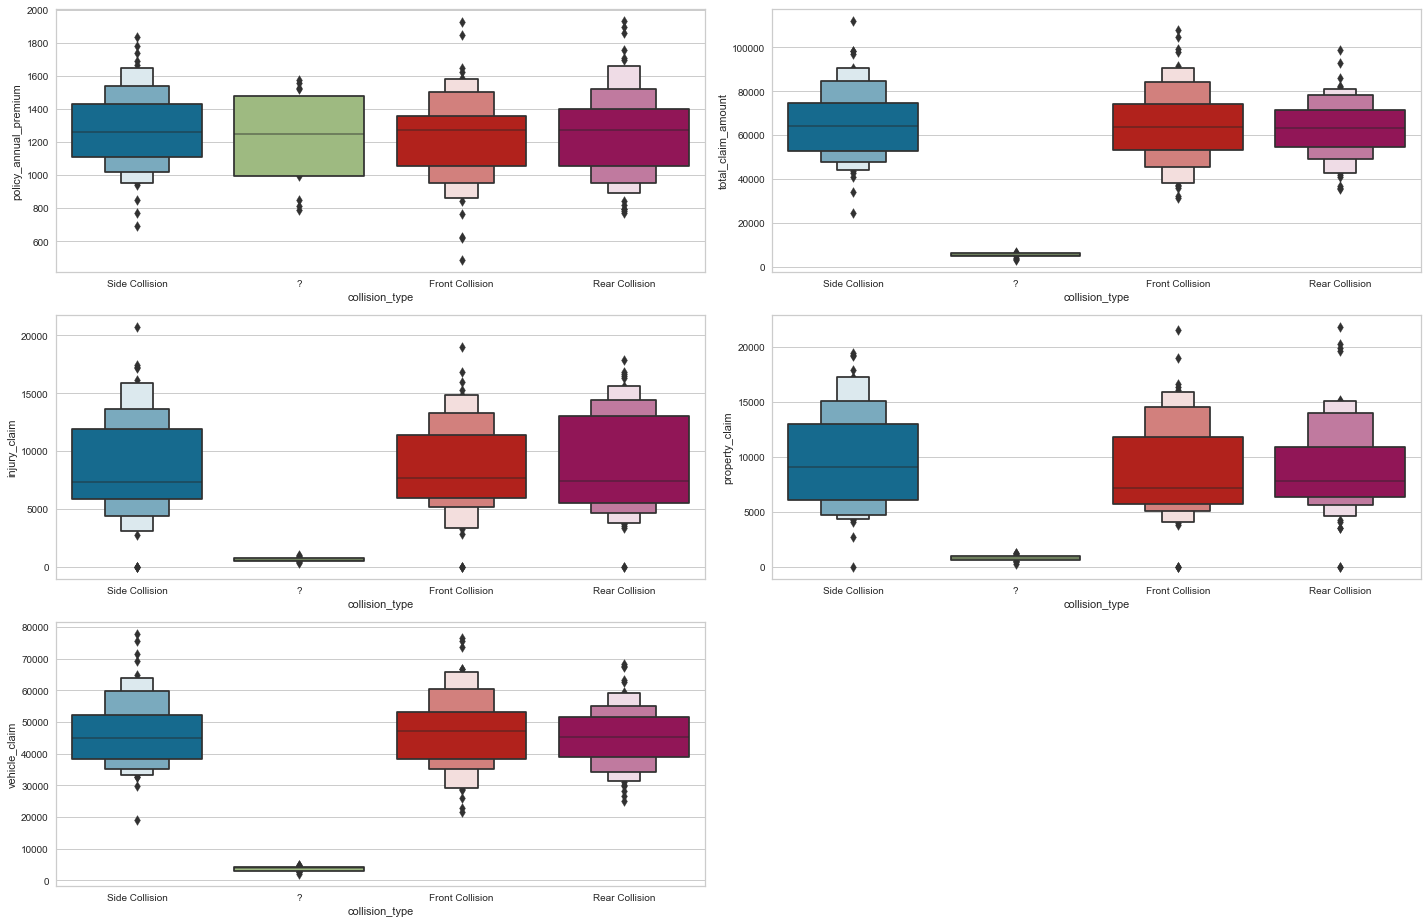

In [18]:
plt.figure(figsize=(20,85))
for i in range(len(col3)):
    plt.subplot(20,2,i+1)
    sns.boxenplot(x=data_no['collision_type'],y=data_no[col3[i]])
    plt.tight_layout()

# Obseravtion

1-People who have claimed fraud insurance they have policy_annual_premium whoes mean value is betwenn 1300 and max value is approx 1800 and where collision type is ? people mostly have claimed 25% to 75% and for front and collision type people have claimed mostly 25% of the value

2-From total_claim_amount vs fraud yes i can say for side and front collision people have claimed maximum of 90000 and for front collision value is around 75000

3-From injury claim where is fraud is yes Side and rear collision have same max value 15000 and mean value of 700 and for injury claim people have claimed mostly 75% to max value and less people are there who claimed for less then 25%

4-From property_claim who have fraud yes i can say side collision have 9000 mean value and 17000 max values and front and rear collision almost have approx values and for side collision mostly people have claimed more then 50% of value same with Front and real collision mostly people have claimed large value that is greater then 50%

5-From vehicle claim where fraud is yes i can say rear and side have almmost same mean value and front have a different value

6-the values that i have mentioned above that means people have claimed these much of money from company in name of fraud means value represent the average value that people have claimed and max value represent the value that the maximum money that people have claimed in name of fraud

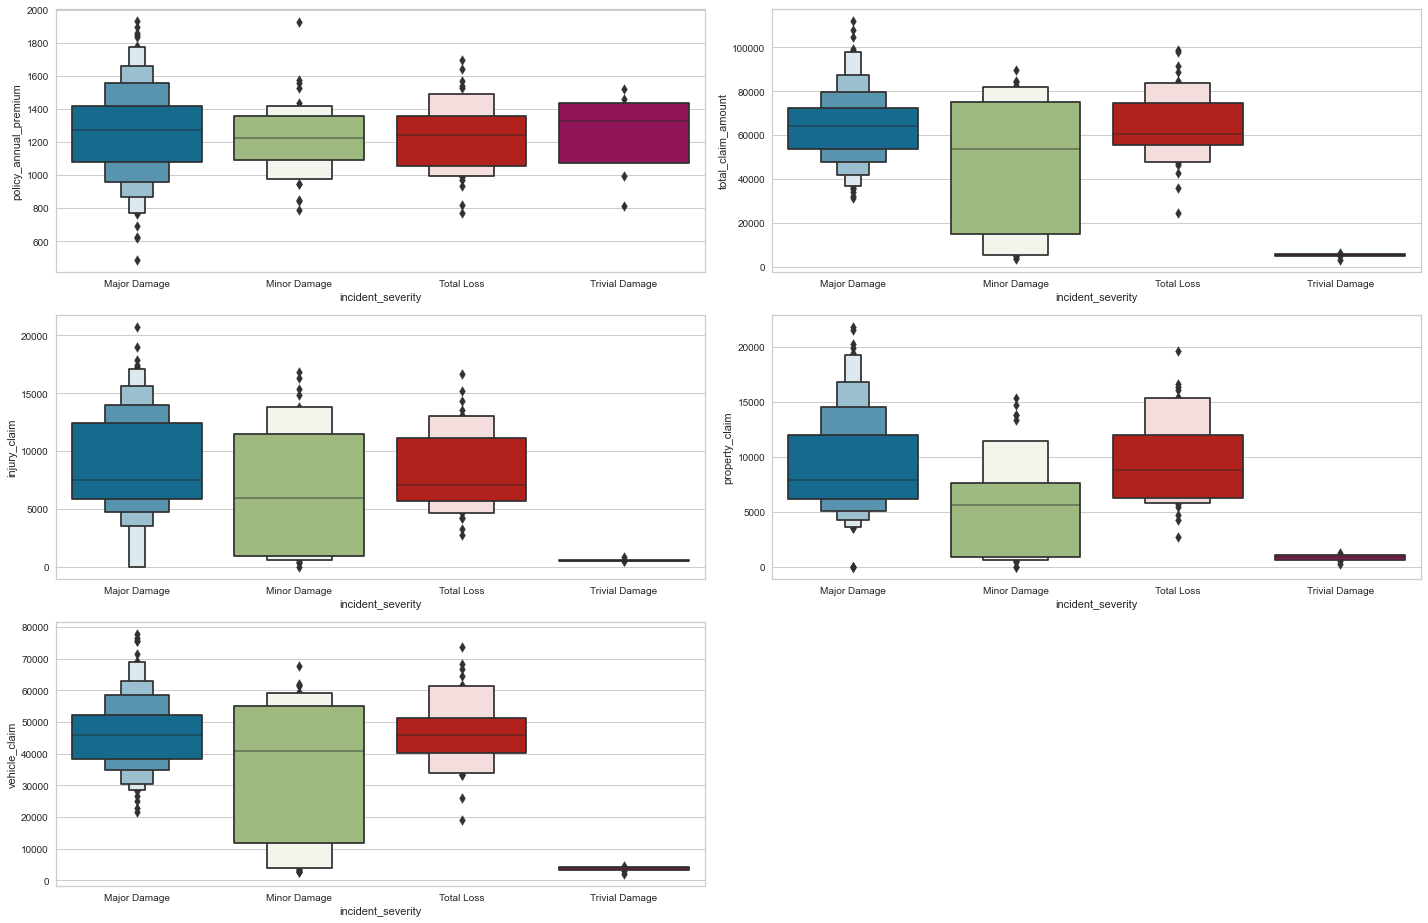

In [19]:
plt.figure(figsize=(20,85))
for i in range(len(col3)):
    plt.subplot(20,2,i+1)
    sns.boxenplot(x=data_no['incident_severity'],y=data_no[col3[i]])
    plt.tight_layout()

# Obseravtion

1-From policy annual premium minor damage i can say mostly people claim value between 25-75% there are some outliers who have claimed for min and max values and For trivial damage i can say mostly people have claim for value that is less then average

2-From total claim amount i can say for minor damage mostly people have value that is less then average i can say 25% of value

3-From injury claim i can say for major damage people have claimed more then the mean and for major damage i can say mostly people have claimed 25% or 75% of value and for total loss i can say mostly people have claimed more then mean value

4-From property claim i can say for major damage the moslty value lies above mean means for major damage people get more money and for minor damage people mostly get value that is less then mean or average

5-From vehicle claim i can say for minor damage people get moslty money that is less then mean less no. of people get money that is greater then mean value

6- and for trivial damage i can say very less amount people will get for all factors

In [20]:
col4=['total_claim_amount',
 'injury_claim',
 'property_claim',
 'vehicle_claim']

(array([1992.5, 1995. , 1997.5, 2000. , 2002.5, 2005. , 2007.5, 2010. ,
        2012.5, 2015. , 2017.5]),
 [Text(0, 1992.5, '1992.5'),
  Text(0, 1995.0, '1995.0'),
  Text(0, 1997.5, '1997.5'),
  Text(0, 2000.0, '2000.0'),
  Text(0, 2002.5, '2002.5'),
  Text(0, 2005.0, '2005.0'),
  Text(0, 2007.5, '2007.5'),
  Text(0, 2010.0, '2010.0'),
  Text(0, 2012.5, '2012.5'),
  Text(0, 2015.0, '2015.0'),
  Text(0, 2017.5, '2017.5')])

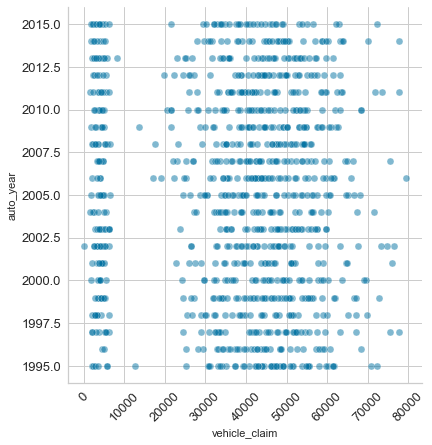

In [21]:
sns.relplot(y='auto_year',x='vehicle_claim',data=data,alpha=.5,palette='muted',sizes=(40,400),height=6)
plt.xticks(rotation=45,fontsize=13)
plt.yticks(fontsize=13)

From upper graph i can say as the year increasing the vehicle calim value is not increasing it is almost same there are some outliers but the value is same

(array([1992.5, 1995. , 1997.5, 2000. , 2002.5, 2005. , 2007.5, 2010. ,
        2012.5, 2015. , 2017.5]),
 [Text(0, 1992.5, '1992.5'),
  Text(0, 1995.0, '1995.0'),
  Text(0, 1997.5, '1997.5'),
  Text(0, 2000.0, '2000.0'),
  Text(0, 2002.5, '2002.5'),
  Text(0, 2005.0, '2005.0'),
  Text(0, 2007.5, '2007.5'),
  Text(0, 2010.0, '2010.0'),
  Text(0, 2012.5, '2012.5'),
  Text(0, 2015.0, '2015.0'),
  Text(0, 2017.5, '2017.5')])

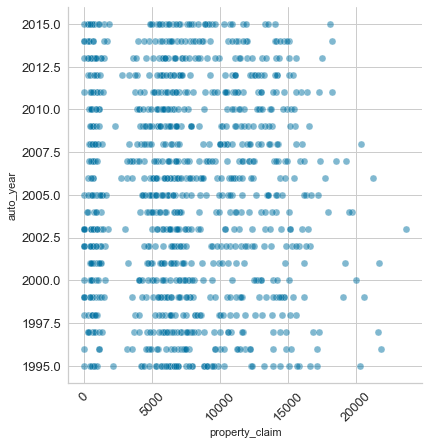

In [22]:
sns.relplot(y='auto_year',x='property_claim',data=data,alpha=.5,palette='muted',sizes=(40,400),height=6)
plt.xticks(rotation=45,fontsize=13)
plt.yticks(fontsize=13)

The property claim value is not increasing as the year increasing it is all same

(array([1992.5, 1995. , 1997.5, 2000. , 2002.5, 2005. , 2007.5, 2010. ,
        2012.5, 2015. , 2017.5]),
 [Text(0, 1992.5, '1992.5'),
  Text(0, 1995.0, '1995.0'),
  Text(0, 1997.5, '1997.5'),
  Text(0, 2000.0, '2000.0'),
  Text(0, 2002.5, '2002.5'),
  Text(0, 2005.0, '2005.0'),
  Text(0, 2007.5, '2007.5'),
  Text(0, 2010.0, '2010.0'),
  Text(0, 2012.5, '2012.5'),
  Text(0, 2015.0, '2015.0'),
  Text(0, 2017.5, '2017.5')])

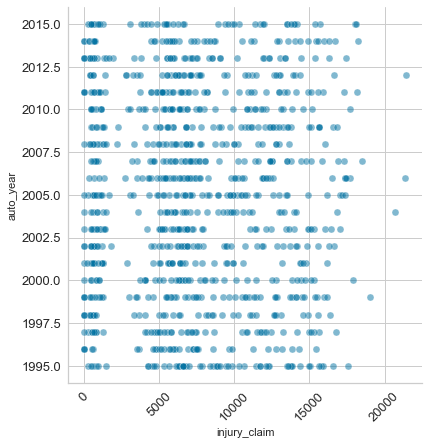

In [23]:
sns.relplot(y='auto_year',x='injury_claim',data=data,alpha=.5,palette='muted',sizes=(40,400),height=6)
plt.xticks(rotation=45,fontsize=13)
plt.yticks(fontsize=13)

(array([1992.5, 1995. , 1997.5, 2000. , 2002.5, 2005. , 2007.5, 2010. ,
        2012.5, 2015. , 2017.5]),
 [Text(0, 1992.5, '1992.5'),
  Text(0, 1995.0, '1995.0'),
  Text(0, 1997.5, '1997.5'),
  Text(0, 2000.0, '2000.0'),
  Text(0, 2002.5, '2002.5'),
  Text(0, 2005.0, '2005.0'),
  Text(0, 2007.5, '2007.5'),
  Text(0, 2010.0, '2010.0'),
  Text(0, 2012.5, '2012.5'),
  Text(0, 2015.0, '2015.0'),
  Text(0, 2017.5, '2017.5')])

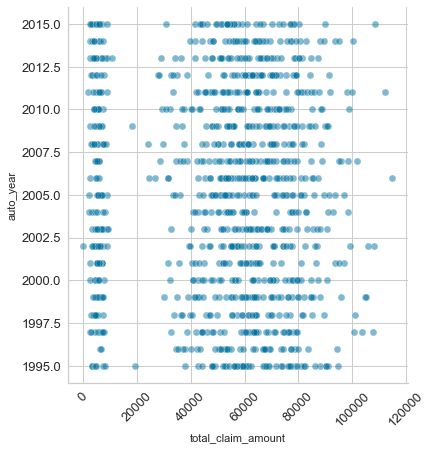

In [24]:
sns.relplot(y='auto_year',x='total_claim_amount',data=data,alpha=.5,palette='muted',sizes=(40,400),height=6)
plt.xticks(rotation=45,fontsize=13)
plt.yticks(fontsize=13)

Total claim amount value is almost same as the year increasing

In [25]:
oe=OrdinalEncoder()
def ordinal_transform(df,col):
    df[col]=oe.fit_transform(df[col])
    return df

Here i am using ordinal encoder because i am gaving all the values in order

In [26]:
data=ordinal_transform(data,['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level','insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type','collision_type', 'incident_severity','authorities_contacted', 'incident_state', 'incident_city','property_damage', 'police_report_available','auto_make','auto_model', 'fraud_reported'])

In [27]:
def preprocess2(df):
    df=df.copy()

    X=data.drop(['fraud_reported'],axis=1)
    y=data['fraud_reported']
    return X,y

Spliting data in dependent and independent variable

In [28]:
X,y=preprocess2(data)

In [29]:
x=X

# Checking correlation

<AxesSubplot:>

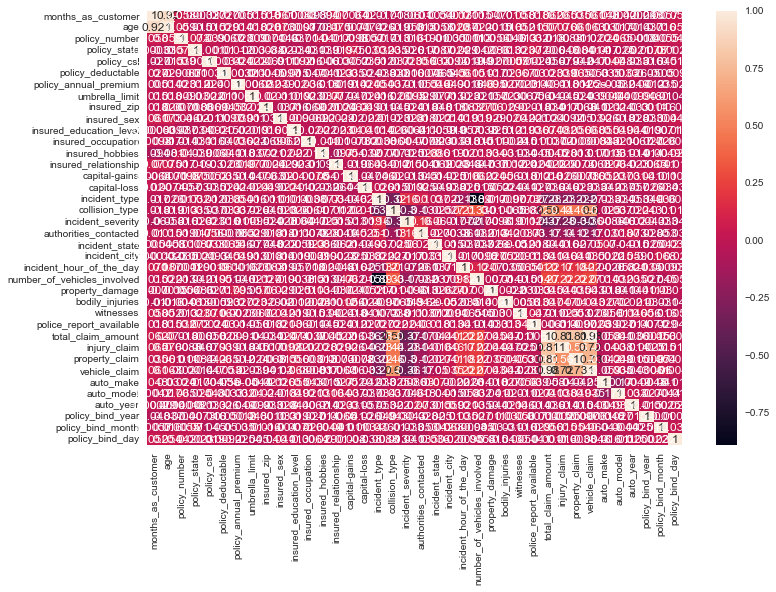

In [30]:
X_corr=X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(X_corr,annot=True)

From heatmap i can say months as customer and age are having correlation more then 90% and rest of all features are having good correlation that is important for building a ML model

In [31]:
X.drop(['months_as_customer'],axis=1,inplace=True)

Dropping this column because it was having high correlation with age

In [32]:
X.dtypes

age                              int64
policy_number                    int64
policy_state                   float64
policy_csl                     float64
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                    float64
insured_education_level        float64
insured_occupation             float64
insured_hobbies                float64
insured_relationship           float64
capital-gains                    int64
capital-loss                     int64
incident_type                  float64
collision_type                 float64
incident_severity              float64
authorities_contacted          float64
incident_state                 float64
incident_city                  float64
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                float64
bodily_injuries                  int64
witnesses                

# Checking Outliers

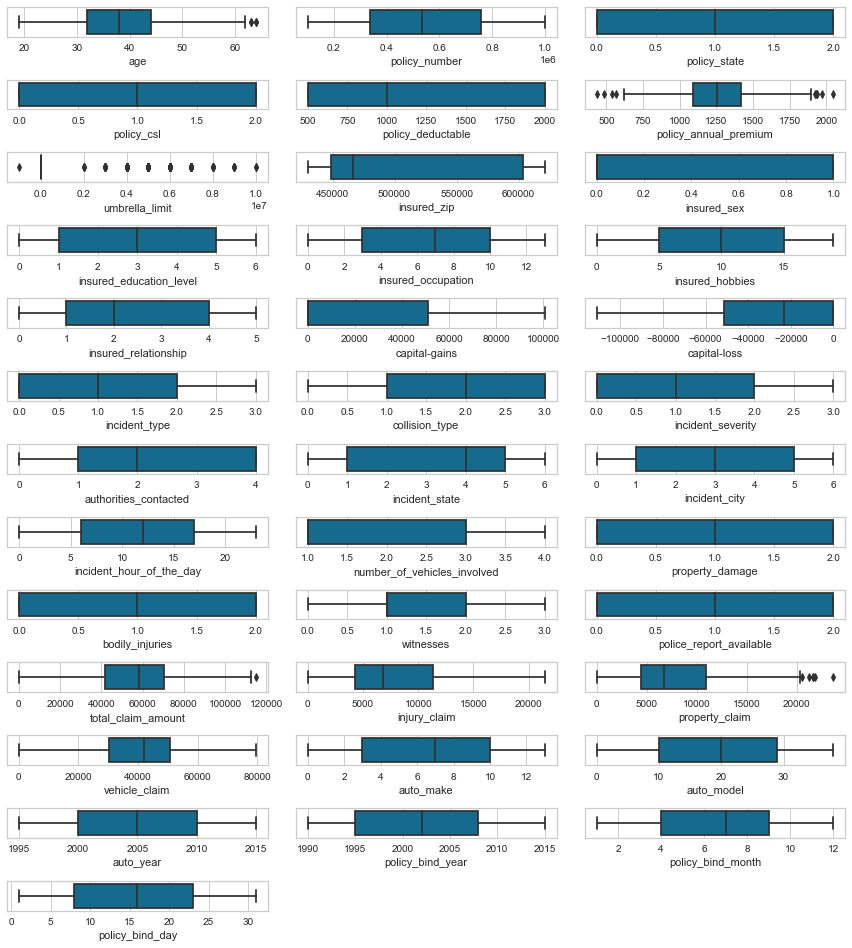

In [33]:
X_val=X.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
    plt.subplot(20,3,i+1)
    sns.boxplot(X[X_val[i]])
    plt.tight_layout()

We have some outliers lets try to remove them

# Removing Outliers by percentile method

In [34]:
for col in X.columns:
    percentile=X[col].quantile([0.01,0.98]).values
    X[col][X[col]<=percentile[0]]=percentile[0]
    X[col][X[col]>=percentile[1]]=percentile[1]

# After Removing Outliers

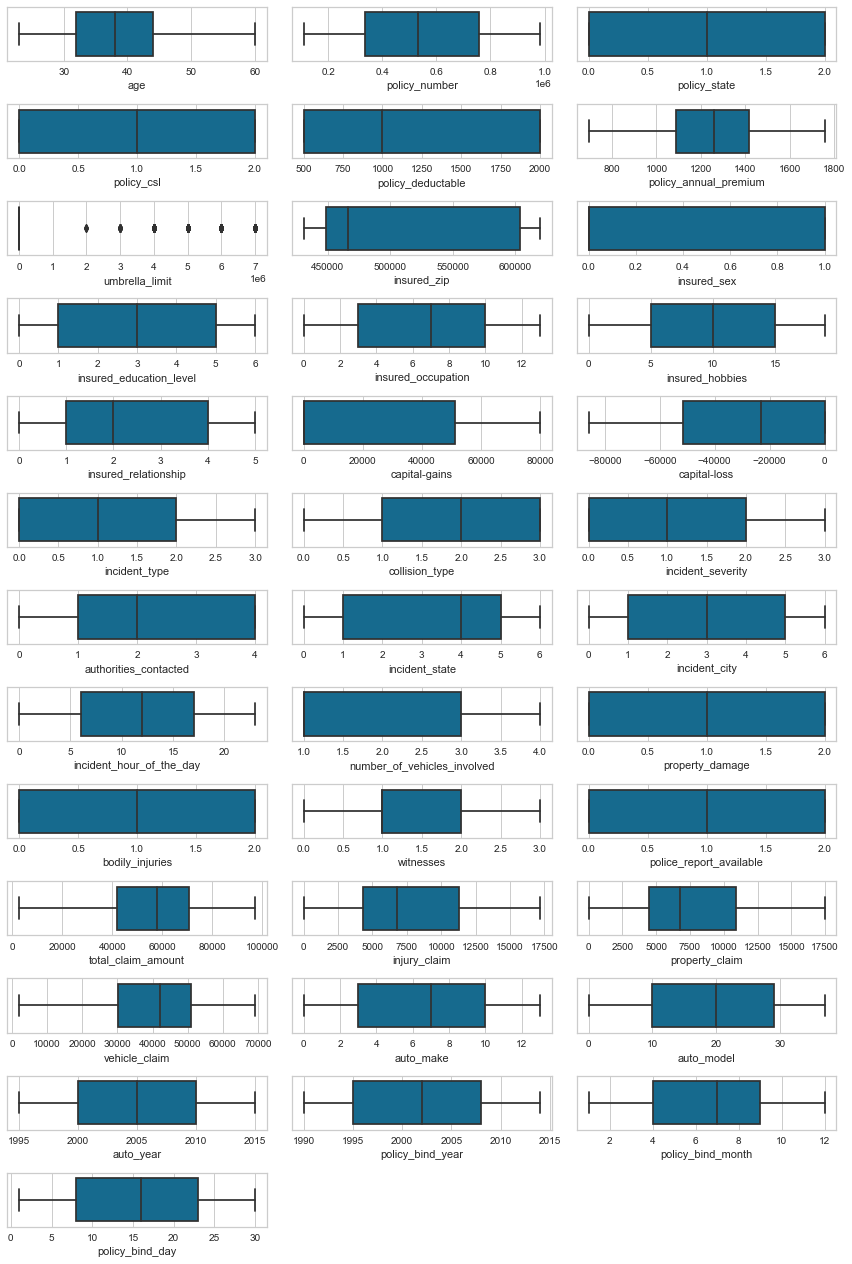

In [35]:
X_val=X.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
    plt.subplot(15,3,i+1)
    sns.boxplot(X[X_val[i]])
    plt.tight_layout()

we have removed all outliers

In [36]:
#!pip install kmeans-smote
from kmeans_smote import KMeansSMOTE

# Balancing the data

In [37]:
def balancing_data(X,y):
    x=X
    smote=SMOTE(random_state=42)
    X_res,y_res=smote.fit_resample(X,y)
    X_new=pd.DataFrame(X_res,columns=x.columns)
    y_new=pd.DataFrame(y_res,columns=['fraud_reported'])
    return X_new,y_new

Data is imbalanced so i am balancing it

In [38]:
X_new,y_new=balancing_data(X,y)

# Checking data after balancing

Yes - 0
No - 1


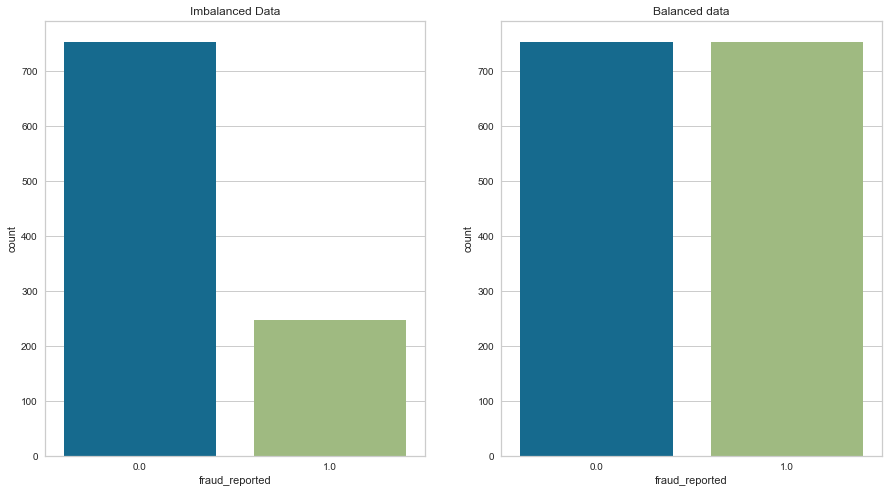

In [39]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.countplot(data['fraud_reported'])
plt.title("Imbalanced Data")
plt.subplot(1,2,2)
sns.countplot(y_new['fraud_reported'])
plt.title("Balanced data")
print("Yes - 0")
print("No - 1")

# Checking skewness

In [40]:
X.skew()

age                            0.461109
policy_number                  0.036105
policy_state                  -0.026177
policy_csl                     0.088928
policy_deductable              0.477887
policy_annual_premium         -0.046551
umbrella_limit                 1.712094
insured_zip                    0.816445
insured_sex                    0.148630
insured_education_level       -0.000148
insured_occupation            -0.058881
insured_hobbies               -0.061563
insured_relationship           0.077488
capital-gains                  0.437885
capital-loss                  -0.366324
incident_type                  0.101507
collision_type                -0.193345
incident_severity              0.279016
authorities_contacted         -0.121744
incident_state                -0.148865
incident_city                  0.049531
incident_hour_of_the_day      -0.035584
number_of_vehicles_involved    0.502664
property_damage                0.106418
bodily_injuries                0.014777


There is no skewness for continuous columns and no need to remove skewness for categorical column

# Spliting data for ML

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y_new,test_size=0.3,random_state=42)

# Using multiple models for training

In [42]:
models={
    "Logistic Regression":LogisticRegression(),
    "DecisionTree Classifier":DecisionTreeClassifier(),
    "ExtraTrees Classifier":ExtraTreesClassifier(),
    "RandomForest Classifier":RandomForestClassifier(),
    "XGB Classifier":XGBClassifier(eval_metric='mlogloss'),
    "LGBM Classifier":LGBMClassifier()
}

********************************************* Logistic Regression *********************************************


Accuracy_Score 0.5685840707964602


SCORE 0.5685840707964602


Confusion metrics


[[125  91]
 [104 132]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.55      0.58      0.56       216
         1.0       0.59      0.56      0.58       236

    accuracy                           0.57       452
   macro avg       0.57      0.57      0.57       452
weighted avg       0.57      0.57      0.57       452

Cross_Val_Score 0.571727794767992


ROC AUC CURVE


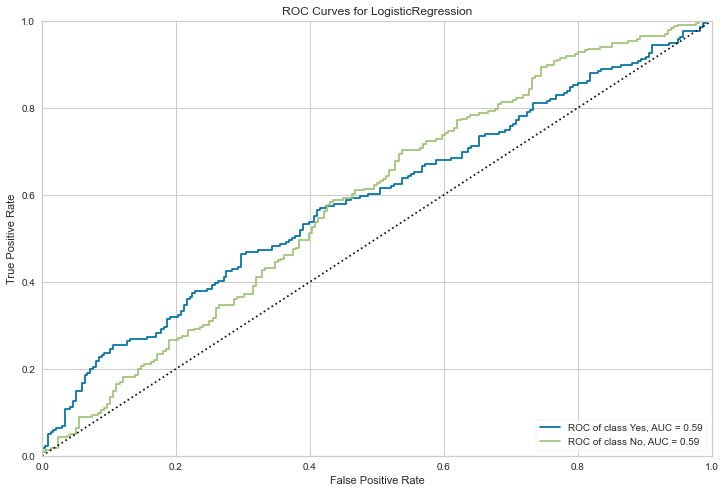

MODEL LEARNING CURVE


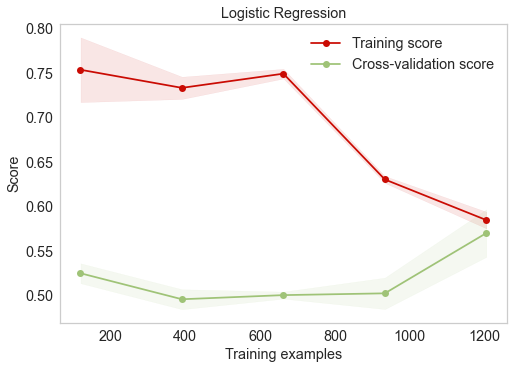

********************************************* DecisionTree Classifier *********************************************


Accuracy_Score 0.8252212389380531


SCORE 0.8252212389380531


Confusion metrics


[[174  42]
 [ 37 199]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       216
         1.0       0.83      0.84      0.83       236

    accuracy                           0.83       452
   macro avg       0.83      0.82      0.82       452
weighted avg       0.83      0.83      0.83       452

Cross_Val_Score 0.8220347187080593


ROC AUC CURVE


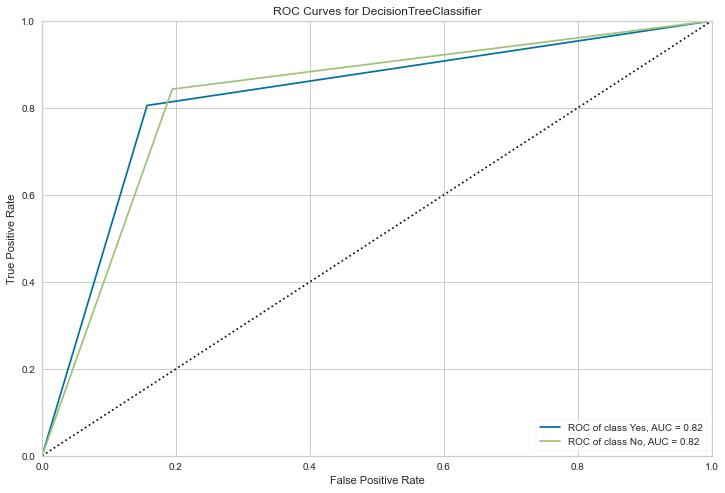

MODEL LEARNING CURVE


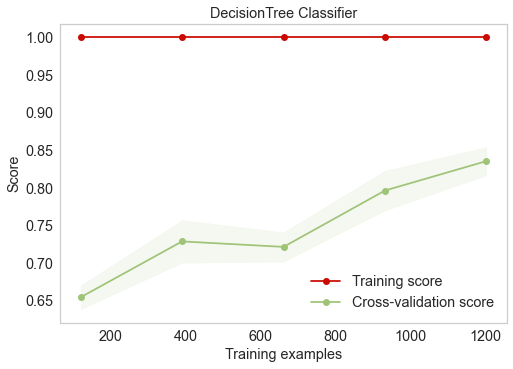

********************************************* ExtraTrees Classifier *********************************************


Accuracy_Score 0.8982300884955752


SCORE 0.8982300884955752


Confusion metrics


[[189  27]
 [ 19 217]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       216
         1.0       0.89      0.92      0.90       236

    accuracy                           0.90       452
   macro avg       0.90      0.90      0.90       452
weighted avg       0.90      0.90      0.90       452

Cross_Val_Score 0.8924512111944732


ROC AUC CURVE


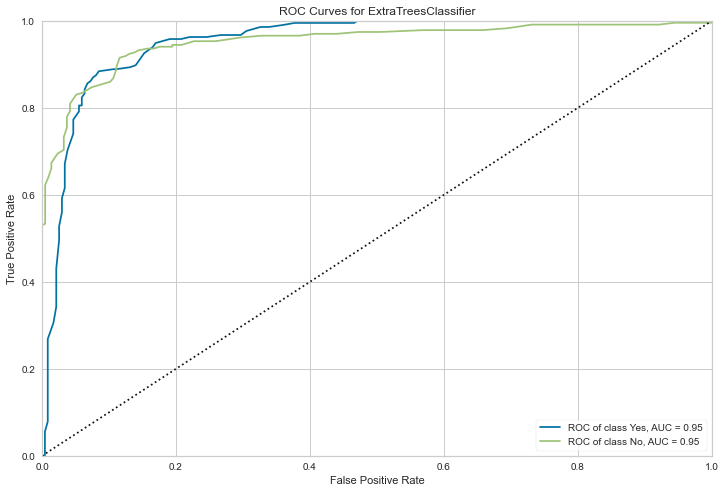

MODEL LEARNING CURVE


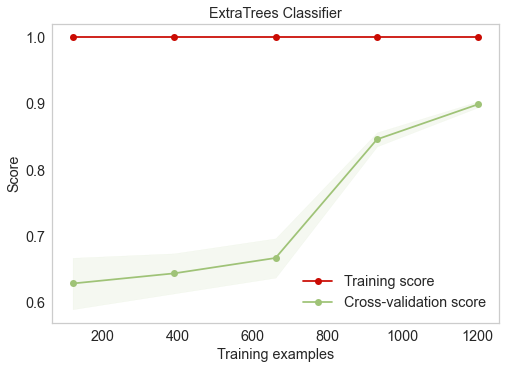

********************************************* RandomForest Classifier *********************************************


Accuracy_Score 0.8561946902654868


SCORE 0.8561946902654868


Confusion metrics


[[185  31]
 [ 34 202]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       216
         1.0       0.87      0.86      0.86       236

    accuracy                           0.86       452
   macro avg       0.86      0.86      0.86       452
weighted avg       0.86      0.86      0.86       452

Cross_Val_Score 0.8731645068315329


ROC AUC CURVE


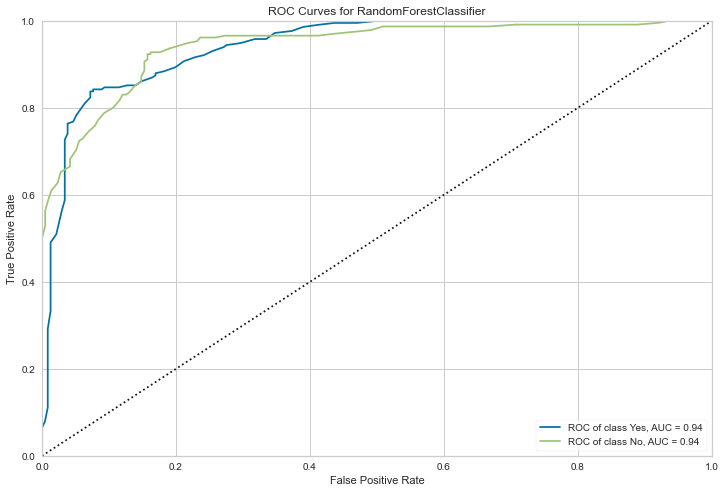

MODEL LEARNING CURVE


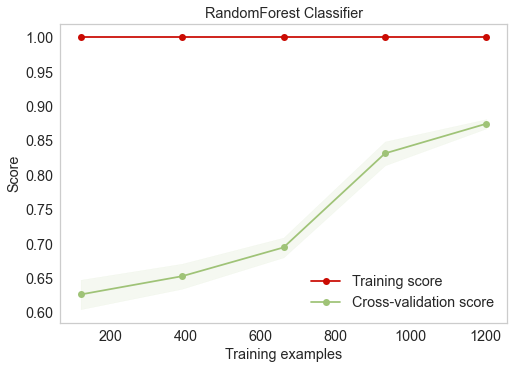

********************************************* XGB Classifier *********************************************


Accuracy_Score 0.8716814159292036


SCORE 0.8716814159292036


Confusion metrics


[[180  36]
 [ 22 214]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86       216
         1.0       0.86      0.91      0.88       236

    accuracy                           0.87       452
   macro avg       0.87      0.87      0.87       452
weighted avg       0.87      0.87      0.87       452

Cross_Val_Score 0.886468944577677


ROC AUC CURVE


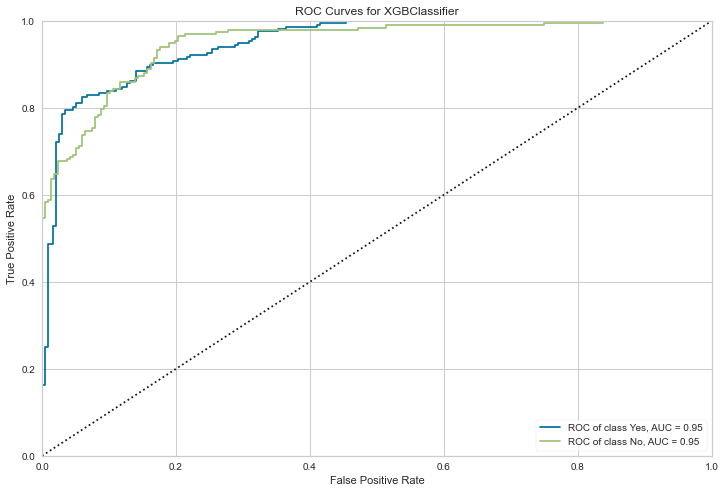

MODEL LEARNING CURVE


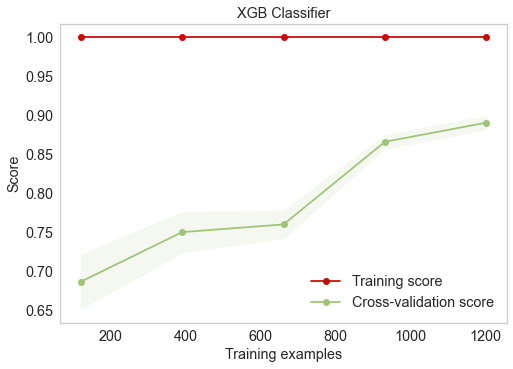

********************************************* LGBM Classifier *********************************************


Accuracy_Score 0.8805309734513275


SCORE 0.8805309734513275


Confusion metrics


[[183  33]
 [ 21 215]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87       216
         1.0       0.87      0.91      0.89       236

    accuracy                           0.88       452
   macro avg       0.88      0.88      0.88       452
weighted avg       0.88      0.88      0.88       452

Cross_Val_Score 0.8884623000594047


ROC AUC CURVE


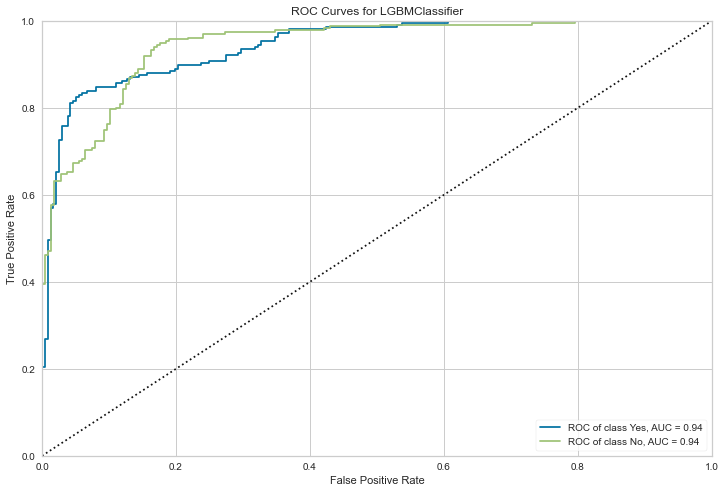

MODEL LEARNING CURVE


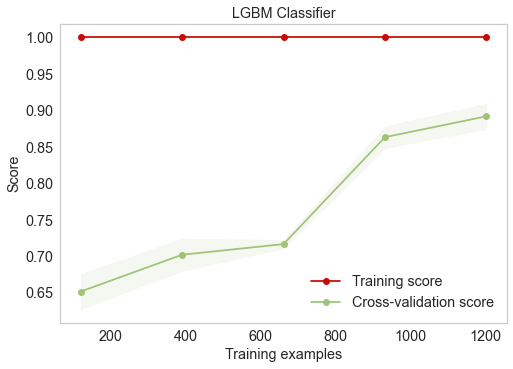

In [43]:
skf=StratifiedKFold(n_splits=5,shuffle=True)
Score=[]
CVS=[]
MODEL=[]
for name,model in models.items():
    print("*********************************************",name,"*********************************************")
    MODEL.append(name)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print('\n')
    ac=accuracy_score(y_test,y_pred)
    Score.append(ac)
    print("Accuracy_Score",ac)
    print('\n')
    print("SCORE",model.score(X_test,y_test))
    print("\n")
    cm=confusion_matrix(y_test,y_pred)
    print('Confusion metrics')
    print('\n')
    print(cm)
    print("CLASSIFICATION REPORT")
    report=classification_report(y_test,y_pred)
    print('\n')
    print(report)
    csv=cross_val_score(model,X_new,y_new,cv=skf).mean()
    CVS.append(csv*100)
    print("Cross_Val_Score",csv)
    print('\n')
    print("ROC AUC CURVE")
    plt.figure(figsize=(12,8))
    roc_auc(model,X_train,y_train,X_test=X_test,y_test=y_test,classes=['Yes','No'],micro=False,macro=False)
    print("MODEL LEARNING CURVE")
    skplt.estimators.plot_learning_curve(model,X_new,y_new,cv=skf,scoring='accuracy',text_fontsize='large',title=name)
    plt.show()

XGBoostClassifier is giving me good accuracy and good metrics so i will do hyperparameter tuning of that only

In [44]:
XGB=XGBClassifier(eval_metric='mlogloss')
XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
XGB.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'mlogloss'}

# Hyperparameter tuning

In [46]:
params={
 'booster':['gbtree','dart'],
 'gamma': [0,1,2,3],
 'importance_type': ['gain','split'],
 'max_depth': [6,5,7],
 'n_estimators': [100,200,500],
}

In [47]:
Grid=GridSearchCV(estimator=XGB,param_grid=params,n_jobs=-1,cv=skf,scoring='accuracy')

In [48]:
Grid.fit(X_new,y_new)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=0, gpu_id=-1,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_...
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                              

In [49]:
Grid.best_params_

{'booster': 'gbtree',
 'gamma': 0,
 'importance_type': 'gain',
 'max_depth': 6,
 'n_estimators': 100}

In [50]:
Grid.best_score_

0.8997381795780072

Accuracy increased from 87.16 to 89.70

In [51]:
Xgb=XGBClassifier(booster= 'gbtree',
 gamma= 1,
 importance_type= 'gain',
 max_depth= 6,
 n_estimators= 100)

In [52]:
Xgb.fit(X_train,y_train)

[14:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Final Model learning curve and roc_auc

ROC AUC CURVE


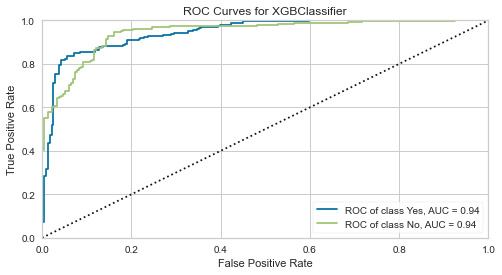

MODEL LEARNING CURVE
[14:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:27] WARNING: C:/Users/Administrator/worksp

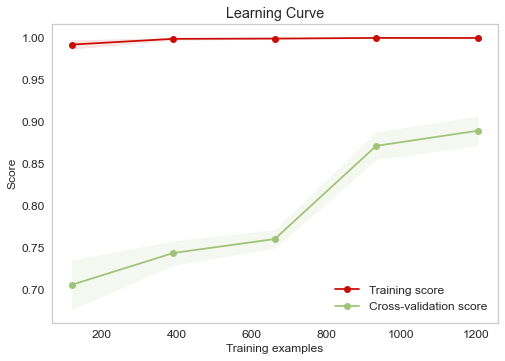

In [53]:
print("ROC AUC CURVE")
plt.figure(figsize=(8,4))
roc_auc(Xgb,X_train,y_train,X_test=X_test,y_test=y_test,classes=['Yes','No'],micro=False,macro=False)
print("MODEL LEARNING CURVE")
skplt.estimators.plot_learning_curve(Xgb,X_new,y_new,cv=skf,scoring='accuracy')
plt.show()

# Final model metrics

In [54]:
y_predicted=Xgb.predict(X_test)
print("Accuracy_score",accuracy_score(y_test,y_predicted))
print("CVS",cross_val_score(Xgb,X_new,y_new,scoring='accuracy',cv=skf).mean())
print("Confusion metrics")
print('\n')
print(confusion_matrix(y_test,y_predicted))
print('\n')
print("Classification Report")
print("\n")
print(classification_report(y_test,y_predicted))

Accuracy_score 0.8915929203539823
[14:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:33] WARNING: C:/Users/Adminis

# Saving model

In [55]:
import joblib
joblib.dump(Grid,"Fraud.obj")

['Fraud.obj']

# Loading Model

In [56]:
model=joblib.load('Fraud.obj')

In [57]:
model.predict(X_test)

array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0.

# Conclusion

1-Did eda on dataset

2-I have writen all the observation how can we found fraud

3-which type of people are doing fraud what education they have what occupation they have is they have child and many more things

4-so we can even analysis what type of people are doing fraud more with partner and who owns a child and all

5-how much amount most they ask for fraud

6-mostly for what collision they ask for fraud

7-i have did complete eda to understand it so we can determine fraud

8-in this data i was having a total imbalanced dataset so i balanced it by Using SMOTE

9-And finally i build a model with good accuracy and other metrics so it can find fraud people